In [80]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import datetime
from scipy.stats import skew, boxcox, norm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score
sns.set(rc = {"figure.figsize":(20, 10)})

In [81]:
#zipfile = zipfile.ZipFile("bank-marketing.zip")

In [82]:
#zipfile.extractall()

In [83]:
#zipfile.close()

In [84]:
data = pd.read_csv("bank-additional-full.csv", sep = ";")

In [85]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [86]:
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

#### Column names are a bit hard to figure out, lets rename them.

In [87]:
data.rename(columns= {"nr.employed":"no_of_Employees",
           "euribor3m":"euribor_3Mon_rate",
                     "cons.conf.idx":"consumer_confidence_idx",
                     "cons.price.idx":"consumer_price_idx",
                     "emp.var.rate":"employ_var_rate"}, inplace=True)

In [88]:
data.head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,employ_var_rate,consumer_price_idx,consumer_confidence_idx,euribor_3Mon_rate,no_of_Employees,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


#### Since y is our target variable lets drop it from our training data beforehand.

In [89]:
y = data["y"]

In [90]:
#y.head()
data.drop(columns="y", inplace=True)

In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
age                        41188 non-null int64
job                        41188 non-null object
marital                    41188 non-null object
education                  41188 non-null object
default                    41188 non-null object
housing                    41188 non-null object
loan                       41188 non-null object
contact                    41188 non-null object
month                      41188 non-null object
day_of_week                41188 non-null object
duration                   41188 non-null int64
campaign                   41188 non-null int64
pdays                      41188 non-null int64
previous                   41188 non-null int64
poutcome                   41188 non-null object
employ_var_rate            41188 non-null float64
consumer_price_idx         41188 non-null float64
consumer_confidence_idx    41188 non-null float64
euribor_3Mo

#### Lets check if we have any null values or not.

In [92]:
data.isnull().sum()

age                        0
job                        0
marital                    0
education                  0
default                    0
housing                    0
loan                       0
contact                    0
month                      0
day_of_week                0
duration                   0
campaign                   0
pdays                      0
previous                   0
poutcome                   0
employ_var_rate            0
consumer_price_idx         0
consumer_confidence_idx    0
euribor_3Mon_rate          0
no_of_Employees            0
dtype: int64

In [93]:
data.describe()

,age,duration,campaign,pdays,previous,employ_var_rate,consumer_price_idx,consumer_confidence_idx,euribor_3Mon_rate,no_of_Employees
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


#### Lets change the duration of campaign from minutes to hours.

In [94]:
data["duration"] = data["duration"]/60

In [95]:
data["month"] = list(map(lambda x: datetime.datetime.strptime(x,"%b").strftime("%m"), data["month"]))

In [96]:
# data.info()

In [97]:
data.describe()

,age,duration,campaign,pdays,previous,employ_var_rate,consumer_price_idx,consumer_confidence_idx,euribor_3Mon_rate,no_of_Employees
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,4.304750,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,4.321321,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,1.700000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,3.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,5.316667,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,81.966667,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


#### Some of the things worth noticing here is:

1. Minimum age is 17 and Maximum age is 98 years old.

2. There has been a campaign of 82 minutes! 

In [98]:
data["job"].value_counts()

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64

#### Most of our clients are employed.

In [99]:
data["marital"].value_counts()

married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64

#### About 60% of our clients are married.

In [100]:
data["education"].value_counts()

university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64

#### 29% of the clients have a university degree.

#### A default on credit is when you fail to pay an expected debt, such as utility charges, mobile phone bills, credit card repayments or loans. Lets see how many customers of our bank have a default.

In [101]:
data["default"].value_counts()

no         32588
unknown     8597
yes            3
Name: default, dtype: int64

In [102]:
data["housing"].value_counts()

yes        21576
no         18622
unknown      990
Name: housing, dtype: int64

In [103]:
data["loan"].value_counts()

no         33950
yes         6248
unknown      990
Name: loan, dtype: int64

#### 82% of the clients of our bank doesnt have any personal loans.

In [104]:
data["contact"].value_counts()

cellular     26144
telephone    15044
Name: contact, dtype: int64

#### 63% of the clients were contacted on cellphones for the campaign.

In [105]:
data["poutcome"].value_counts()

nonexistent    35563
failure         4252
success         1373
Name: poutcome, dtype: int64

#### The success rate of the previous marketing campaigns have been low!

Text(0.5, 1.0, 'Age of Clients')

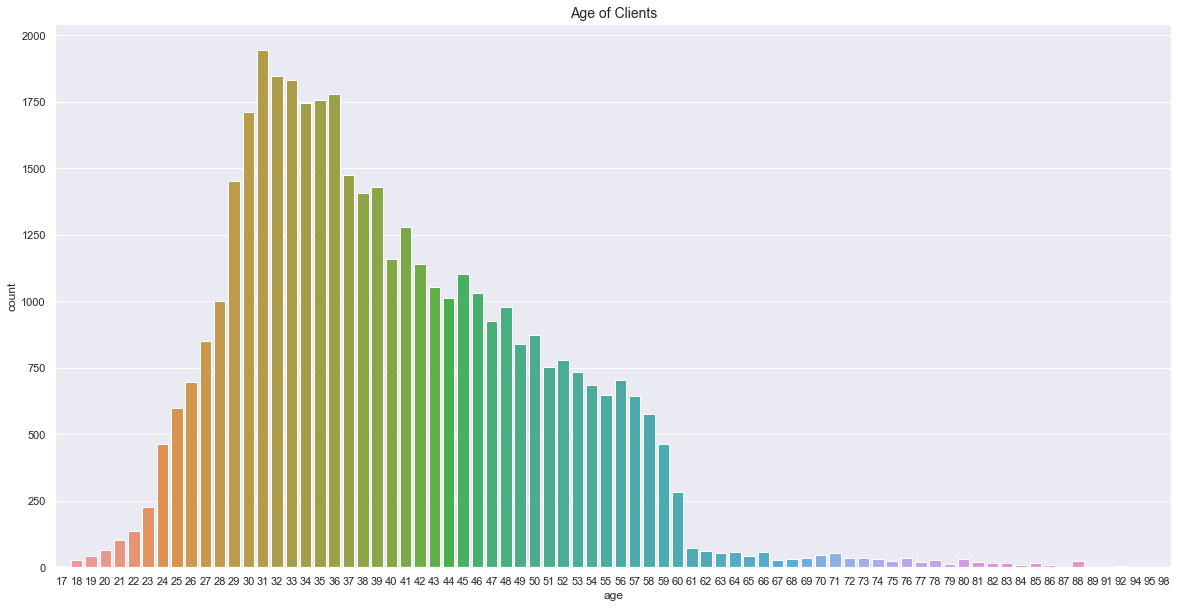

In [106]:
sns.countplot(data["age"])
plt.title("Age of Clients", fontsize = 14)

#### Most of the clients age from 29 - 37.

Text(0.5, 1.0, 'Number of contacts performed during the campaign')

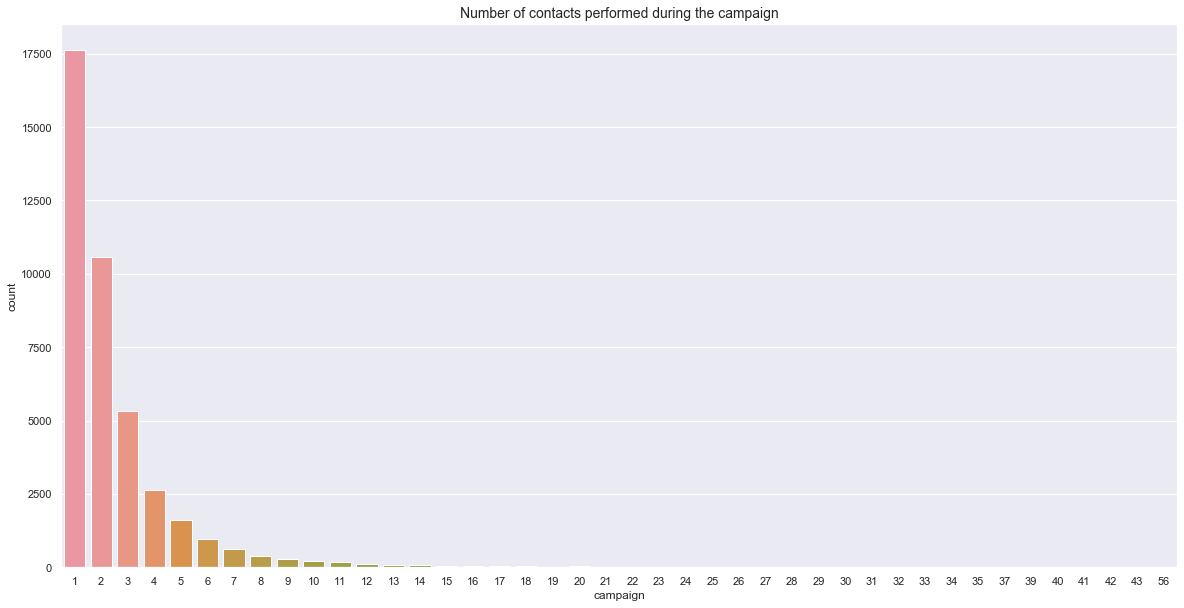

In [107]:
sns.countplot(data["campaign"])
plt.title("Number of contacts performed during the campaign", fontsize = 14)

Text(0.5, 1.0, 'Employment Variation Rate')

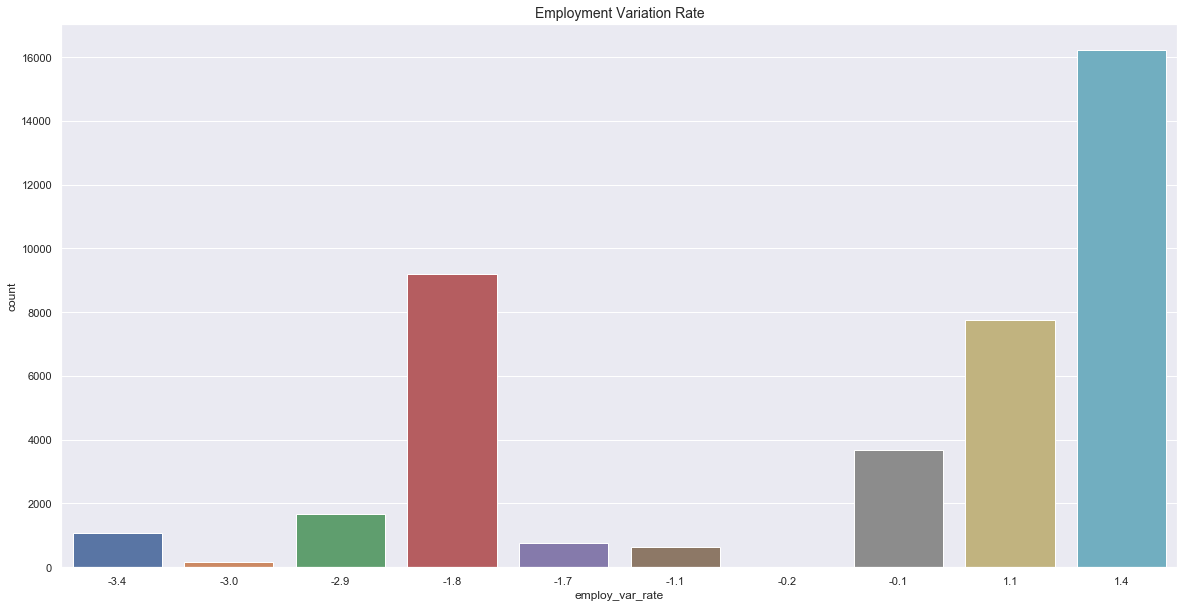

In [108]:
sns.countplot(data["employ_var_rate"])
plt.title("Employment Variation Rate",fontsize = 14)

Text(0.5, 1.0, 'Month that the clients were last contacted')

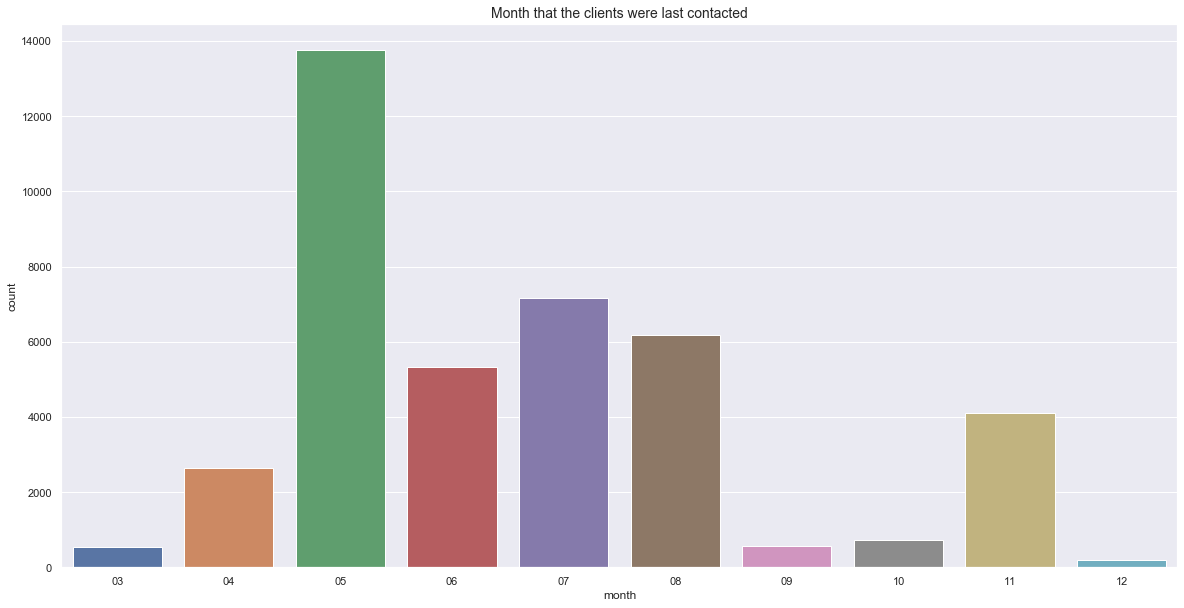

In [109]:
sns.countplot(data["month"])
plt.title("Month that the clients were last contacted", fontsize = 14)

#### May has been the month when the highest number of contacts were made, whereas December has seen the lowest contacts.

Text(0.5, 1.0, 'Day of the week when the clients were last contacted')

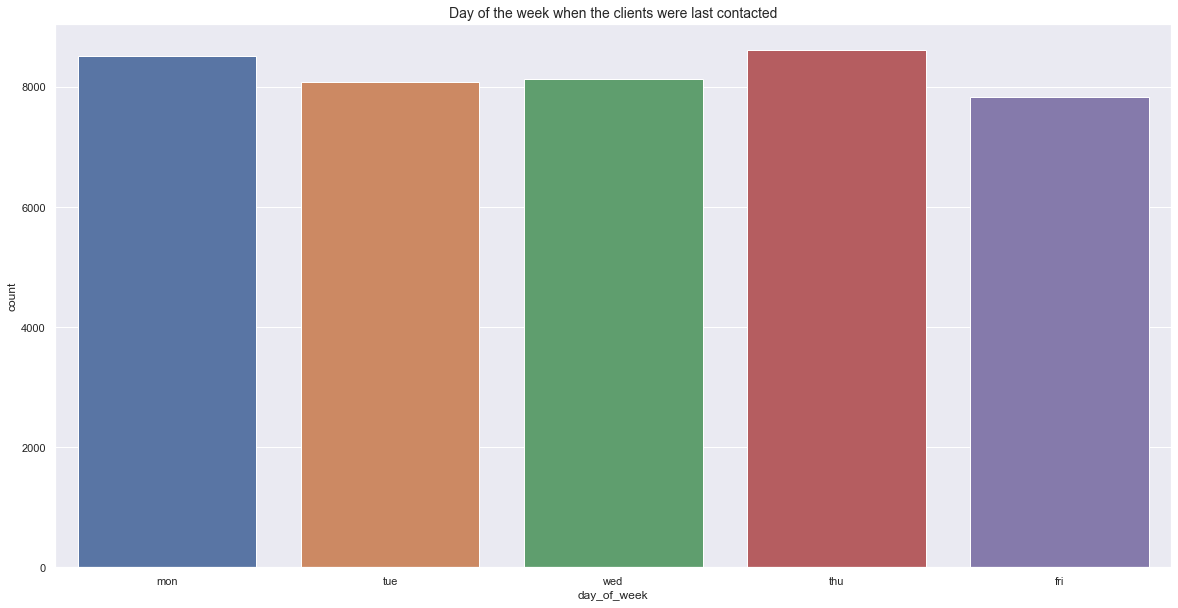

In [110]:
sns.countplot(data["day_of_week"])
plt.title("Day of the week when the clients were last contacted", fontsize = 14)

#### Mondays are when the clients are contacted the most and Friday the least, maybe because of the reason that clients are mostly in the weekend vibes.

#### The Consumer Price Index is a monthly measurement of U.S. prices for most household goods and services. It reports inflation, or rising prices, and deflation, or falling prices.The Bureau of Labor Statistics surveys the prices of 80,000 consumer items to create the index. It represents the prices of a cross-section of goods and services commonly bought by primarily urban households. They represent 87% of the U.S. population.


#### CPI is widely used as an economic indicator. It is the most widely used measure of inflation and, by proxy, of the effectiveness of the government’s economic policy. The CPI gives the government, businesses, and citizens an idea about prices changes in the economy, and can act as a guide in order to make informed decisions about the economy. 

#### The CPI and the components that make it up can also be used as a deflator for other economic factors, including retail sales, hourly/weekly earnings and the value of a consumer’s dollar to find its purchasing power. In this case, the dollar’s purchasing power declines when prices increase. 

#### The index can also be used to adjust people’s eligibility levels for certain types of government assistance including Social Security and it automatically provides the cost-of-living wage adjustments to domestic workers. 

Source: Investopedia

Text(0.5, 1.0, 'Consumer Price Index vs Month')

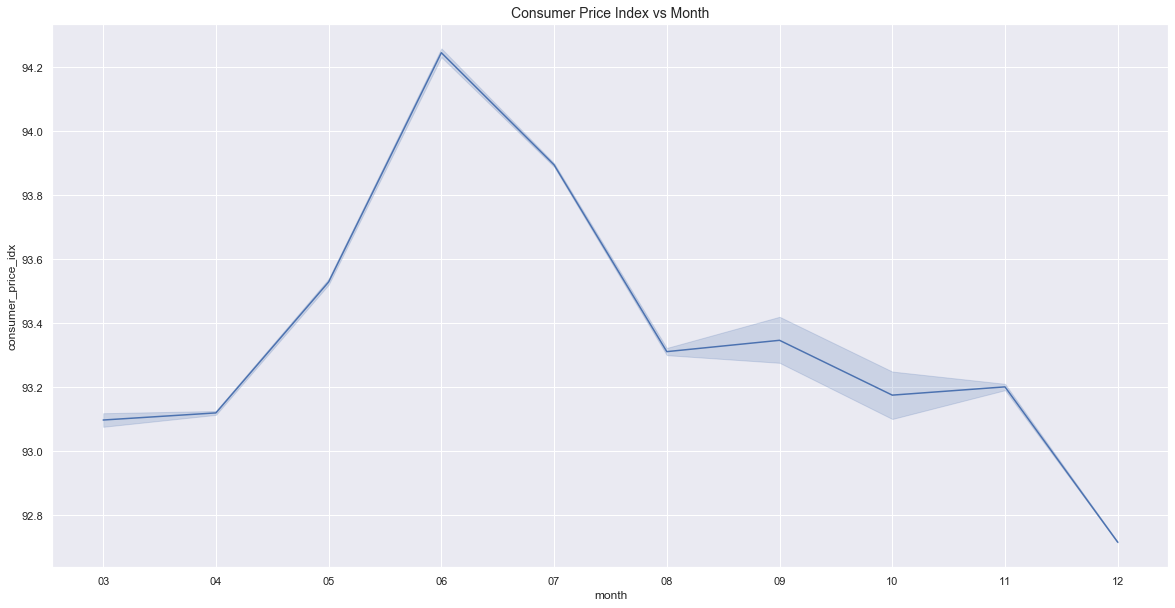

In [111]:
sns.lineplot(x = "month", y = "consumer_price_idx", data = data)
plt.title("Consumer Price Index vs Month", fontsize = 14)

#### Manufacturers, retailers, banks and the government monitor changes in the CCI in order to factor in the data in their decision-making processes. While index changes of less than 5% are often dismissed as inconsequential, moves of 5% or more often indicate a change in the direction of the economy.

#### A month-on-month decreasing trend suggests consumers have a negative outlook on their ability to secure and retain good jobs. Thus, manufacturers may expect consumers to avoid retail purchases, particularly large-ticket items that require financing. Manufacturers may pare down inventories to reduce overhead and/or delay investing in new projects and facilities. Likewise, banks can anticipate a decrease in lending activity, mortgage applications and credit card use. When faced with a down-trending index, the government has a variety of options, such as issuing a tax rebate or taking other fiscal or monetary action to stimulate the economy.

#### Conversely, a rising trend in consumer confidence indicates improvements in consumer buying patterns. Manufacturers can increase production and hiring. Banks can expect increased demand for credit. Builders can prepare for a rise in home construction and government can anticipate improved tax revenues based on the increase in consumer spending. 

Source - Wikipedia (Consumer Confidence Index)

Text(0.5, 1.0, 'Consumer Confidence Index vs Month')

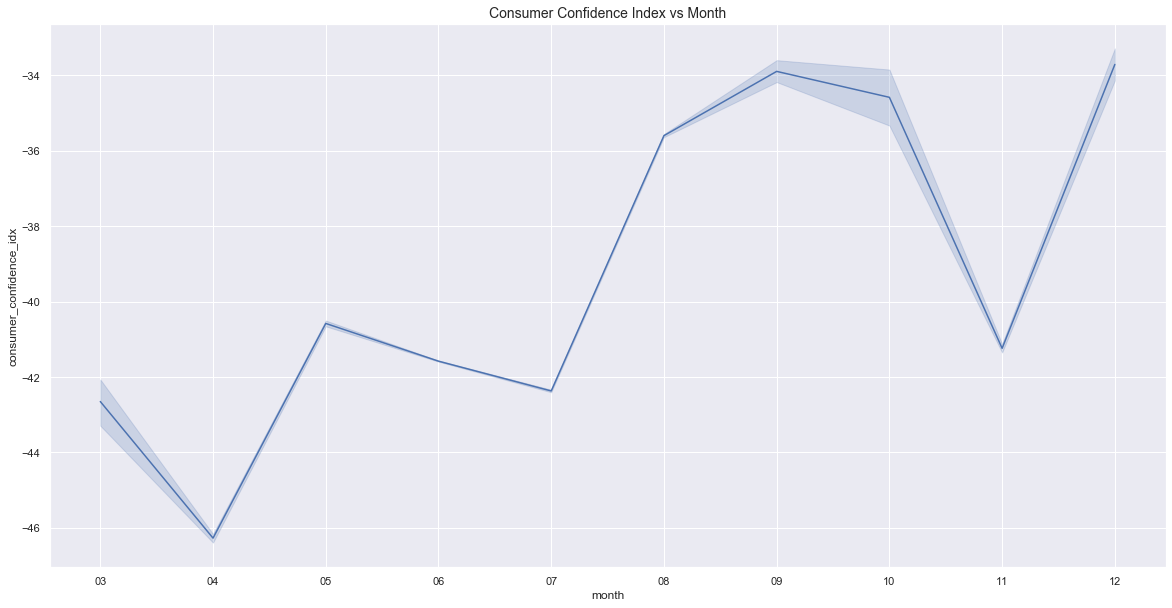

In [112]:
sns.lineplot(x = "month", y = "consumer_confidence_idx", data = data)
plt.title("Consumer Confidence Index vs Month", fontsize = 14)

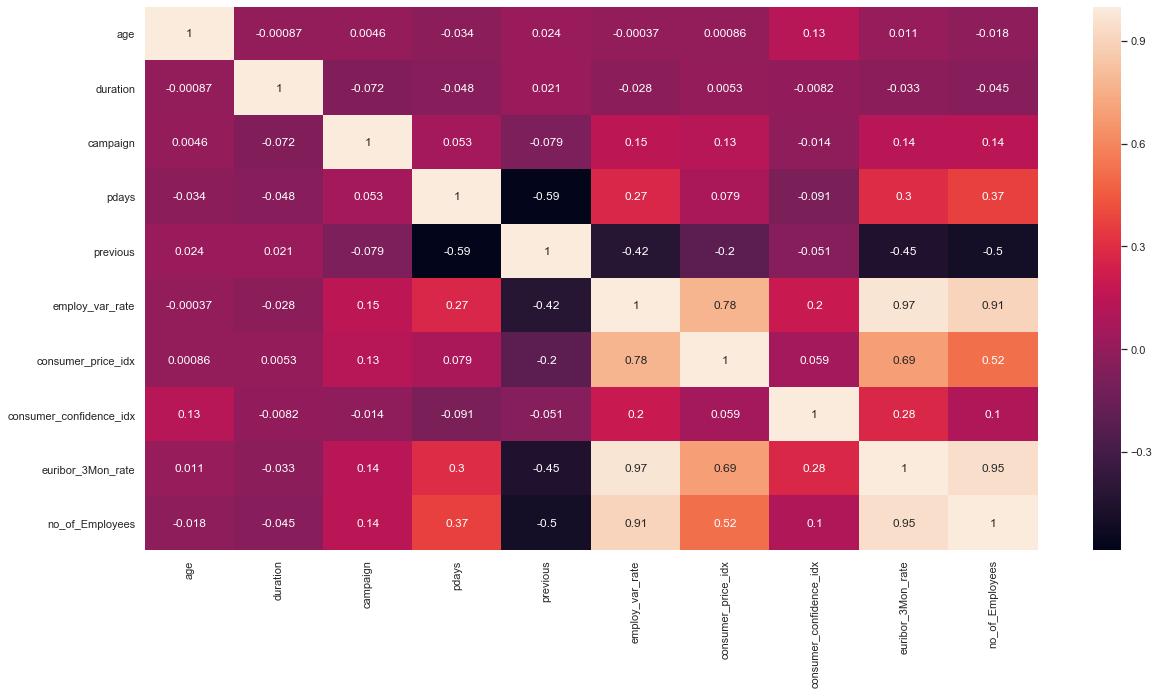

In [113]:
sns.heatmap(data.corr(), annot=True)

#### Lets see if our data is skewed or not.

In [114]:
for column in data[["age","duration","campaign","pdays","previous","employ_var_rate","consumer_price_idx",
                    "consumer_confidence_idx","euribor_3Mon_rate","no_of_Employees"]]:
    print("The skewness of {0} is: {1}".format(column, skew(data[column])))

The skewness of age is: 0.7846682380932289
The skewness of duration is: 3.2630224157610437
The skewness of campaign is: 4.762333252560971
The skewness of pdays is: -4.922010656450045
The skewness of previous is: 3.8319026847007014
The skewness of employ_var_rate is: -0.7240691785977529
The skewness of consumer_price_idx is: -0.23087924271977578
The skewness of consumer_confidence_idx is: 0.3031688173189229
The skewness of euribor_3Mon_rate is: -0.7091621286441162
The skewness of no_of_Employees is: -1.0442243763652297


#### Lets deal with the highly skewed data. Since the data ranges from 0 - 1 applying log transformations will result in NaN since log of 0 is undefined so we will add to our data which wont lets us run into an error.Later on we will apply boxcox transformation ot remove the skewness of our data.

In [115]:
data["previous"].min()

0

In [116]:
for column in data[["duration", "pdays", "previous"]]:
                  data[column] =+ 1

In [117]:
for column in data[["duration", "campaign", "pdays", "previous"]]:
                  data[column] = boxcox(np.asarray(data[[column]].values))[0]

/home/daminijain/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:910: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/home/daminijain/.local/lib/python3.6/site-packages/scipy/optimize/optimize.py:1959: RuntimeWarning: invalid value encountered in subtract
  tmp1 = (x - w) * (fx - fv)
/home/daminijain/.local/lib/python3.6/site-packages/scipy/optimize/optimize.py:1960: RuntimeWarning: invalid value encountered in subtract
  tmp2 = (x - v) * (fx - fw)


#### Lets check the skewness of the columns we just transformed.

In [118]:
for column in data[["duration", "campaign", "pdays", "previous"]]:
    print("The skewness of {0} is: {1}".format(column, skew(data[column])))

The skewness of duration is: 0.0
The skewness of campaign is: 0.20595105793082727
The skewness of pdays is: 0.0
The skewness of previous is: 0.0


#### Lets convert the categorical features to numerical for able to feed them to our model.

In [119]:
labelencoder = LabelEncoder()

In [120]:
categorical_columns = ["job", "marital", "education", "default", "housing", "loan", "contact", 
                      "day_of_week", "poutcome", "month"]

In [121]:
data[categorical_columns] = data[categorical_columns].apply(lambda column: labelencoder.fit_transform(column))

In [122]:
#data.head(10)

In [123]:
y = labelencoder.fit_transform(y)

In [124]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size = 0.2, stratify = y)

In [125]:
lr = LogisticRegression(random_state=0)

In [126]:
lr.fit(X_train, y_train)

/home/daminijain/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [127]:
lr_y_pred = lr.predict(X_test)

In [128]:
print("Accuracy of Logistic Regression model is: ", accuracy_score(y_test, lr_y_pred))

Accuracy of Logistic Regression model is:  0.9002184996358339


In [129]:
def plot_roc(model_preds, model_original):
    false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(model_original, model_preds)
    
    plt.subplots(1, figsize=(10,10))
    plt.plot(false_positive_rate1, true_positive_rate1)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title("ROC curve of Model", fontsize = 14)
    plt.show()

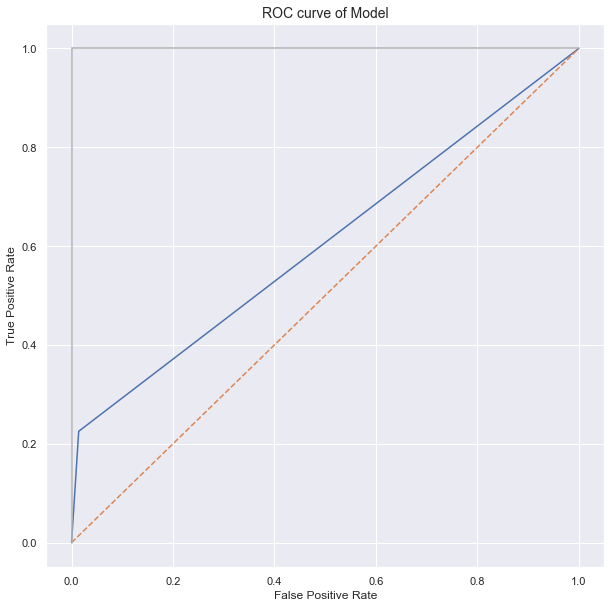

In [130]:
plot_roc(lr_y_pred, y_test)

In [131]:
rf = RandomForestClassifier(n_estimators=15, criterion="gini", random_state=0)

In [132]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [133]:
forest_y_pred = rf.predict(X_test)

In [134]:
print("Accuracy of Random Forest Classfier is:",accuracy_score(y_test, forest_y_pred))

Accuracy of Random Forest Classfier is: 0.8924496236950716


In [157]:
feature_imp = pd.Series(rf.feature_importances_ ,index = data.columns).sort_values(ascending=False)

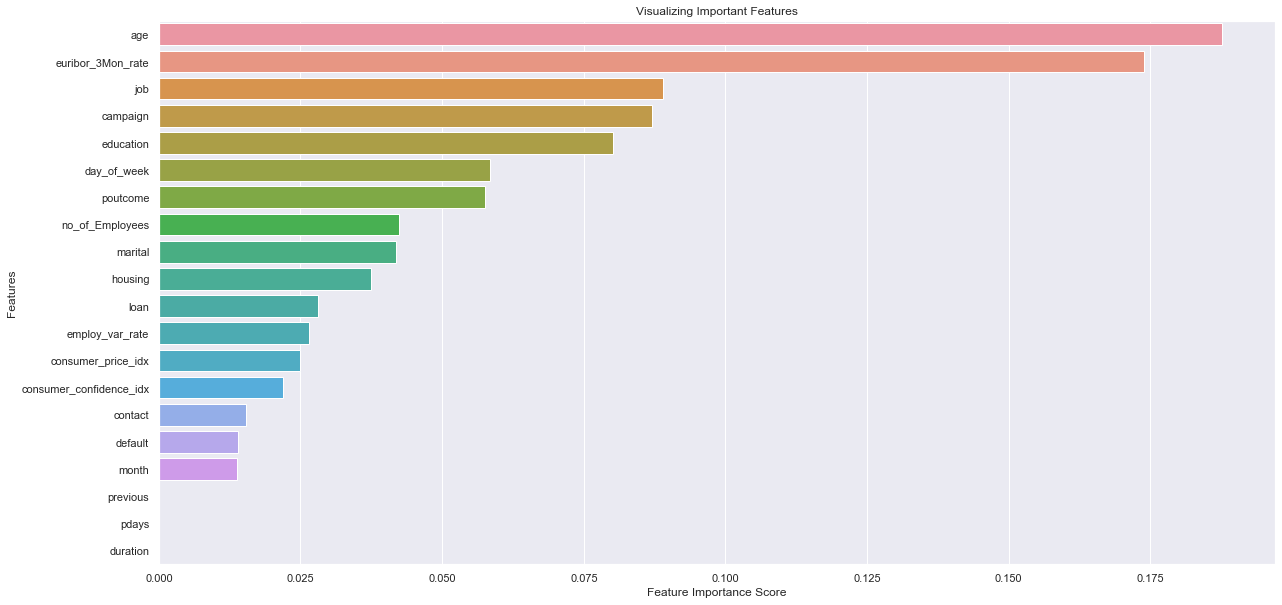

In [158]:
sns.barplot(x = feature_imp, y = feature_imp.index)
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Visualizing Important Features")
plt.show()

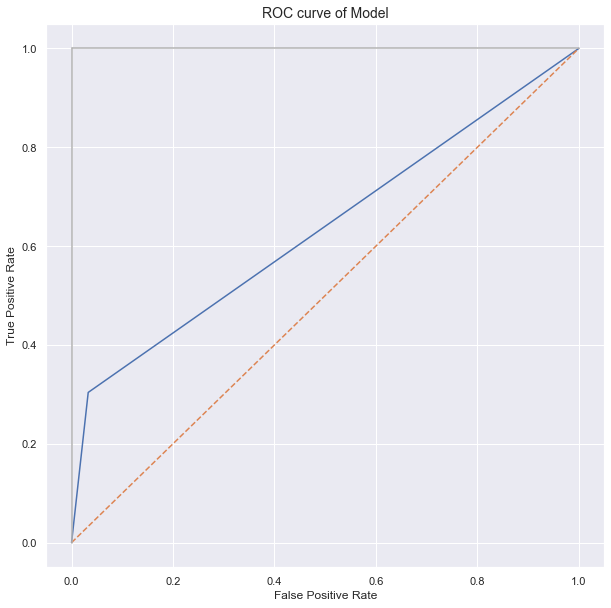

In [135]:
plot_roc(forest_y_pred, y_test)

In [136]:
knn = KNeighborsClassifier(n_neighbors=7, metric = 'minkowski', p = 3)

In [137]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=7, p=3,
           weights='uniform')

In [138]:
y_pred_knn = knn.predict(X_test)

In [139]:
print("Accuracy of KNN is:",accuracy_score(y_test, y_pred_knn))

Accuracy of KNN is: 0.8900218499635834


In [140]:
svc = SVC(kernel = "rbf", random_state=0)

In [141]:
svc.fit(X_train, y_train)

/home/daminijain/.local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=0,
  shrinking=True, tol=0.001, verbose=False)

In [142]:
y_pred_svc = svc.predict(X_test)

In [143]:
print("Accuracy of SVC is:",accuracy_score(y_test, y_pred_svc))

Accuracy of SVC is: 0.8902646273367322


In [144]:
tree = DecisionTreeClassifier(criterion="entropy", random_state=0)

In [145]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [146]:
y_pred_tree = tree.predict(X_test)

In [147]:
print("Accuracy of tree is:",accuracy_score(y_test, y_pred_tree))

Accuracy of tree is: 0.8421947074532653


In [148]:
bayes = GaussianNB()

In [149]:
bayes.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [150]:
y_pred_bayes = bayes.predict(X_test)

In [151]:
print("Accuracy of tree is:",accuracy_score(y_test, y_pred_bayes))

Accuracy of tree is: 0.7685117747025977


In [152]:
xboost = XGBClassifier()

In [153]:
xboost.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [154]:
y_pred_boost = xboost.predict(X_test)

In [155]:
print("Accuracy of boost is:",accuracy_score(y_test, y_pred_boost))

Accuracy of boost is: 0.9007040543821316
